## Step 0: Read image

In [39]:
%matplotlib inline
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

IMAGE_PATH = "images/1.jpg"

BLOCK_WIDTH = 8 #modify it if you want, maximal 8 due to default quantization table is 8*8
BLOCK_WIDTH = max(2, min(8, BLOCK_WIDTH))
BLOCK_HEIGHT = BLOCK_WIDTH

(-0.5, 719.5, 472.5, -0.5)

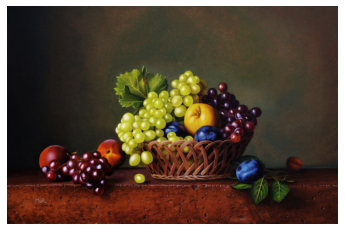

In [2]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread(IMAGE_PATH, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# img = scipy.misc.face()

xLen = img.shape[1]//BLOCK_WIDTH
yLen = img.shape[0]//BLOCK_HEIGHT

plt.imshow(img)
plt.axis('off')

## Step 1: RGB -> YCbCr

$\begin{bmatrix}
Y \\
Cb \\
Cr \\
\end{bmatrix} = \begin{bmatrix}
0.299 & 0.587 & 0.114 \\
-0.168736 & -0.331264 & 0.5 \\
0.5 & -0.418688 & -0.081312 \\
\end{bmatrix} \begin{bmatrix}
R \\
G \\
B \\
\end{bmatrix} + \begin{bmatrix}
16 \\
128 \\
128 \\
\end{bmatrix}
$

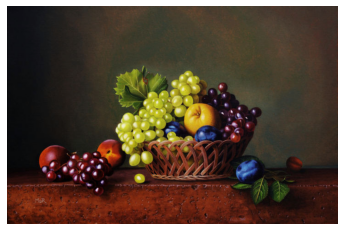

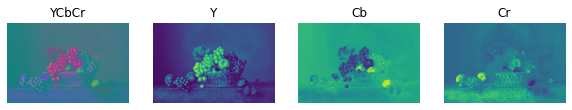

In [3]:
from skimage.color import rgb2ycbcr,ycbcr2rgb
lb = ['YCbCr', 'Y', 'Cb', 'Cr']

def YCbCr2RGB(ycbcr):
  return (ycbcr2rgb(ycbcr).clip(0,1)*255).astype(np.uint8)

img = cv2.imread(IMAGE_PATH, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ycbcr = rgb2ycbcr(img)
rgb = YCbCr2RGB(ycbcr)

plt.imshow(rgb)
plt.axis('off')

fig = plt.figure(figsize=(10, 10))
for i in range(len(lb)):
    toShow = ycbcr.astype(np.uint8) if i==0 else ycbcr[:,:,i-1]
    plt.subplot(1, len(lb),i+1) 
    plt.imshow(toShow)
    plt.axis('off')
    plt.title(lb[i])

if (useYCbCr):
  img = ycbcr

## Step 2: Transform the image into blocks

In [4]:
def toBlocks(img):
  blocks = np.zeros((yLen, xLen, BLOCK_HEIGHT, BLOCK_WIDTH, 3), dtype=np.int16)

  for y in range(yLen):
    for x in range(xLen):
      blocks[y, x] = img[y*BLOCK_HEIGHT:(y+1)*BLOCK_HEIGHT, x*BLOCK_WIDTH:(x+1)*BLOCK_WIDTH]
      
  return np.array(blocks)

def plotBlocks(blocks, gray=False):
  xLen = blocks.shape[1]
  yLen = blocks.shape[0]

  for y in range(yLen):
    for x in range(xLen):
      plt.subplot(yLen,xLen,1+xLen*y+x)
      plt.imshow(blocks[y, x], cmap=plt.cm.gray if gray else plt.cm.Accent)
      plt.axis('off')

blocks = toBlocks(img)

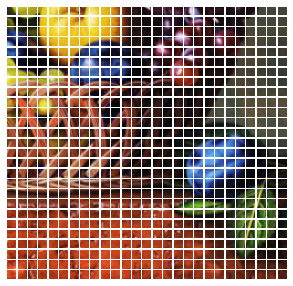

In [5]:
BLOCK_PLOT = 27
xStart = int(0.5*xLen)
yStart = int(0.5*yLen)
plt.figure(figsize=(5,5))

if(useYCbCr):
  def ycbcrBlock2rgb(block):
    return (ycbcr2rgb(block)*(255/ycbcr2rgb(block).max())).astype(np.uint8)
  plotBlocks(np.array(list(map(ycbcrBlock2rgb,blocks[yStart:yStart + BLOCK_PLOT, xStart:xStart + BLOCK_PLOT]))))
else:
  plotBlocks(blocks[yStart:yStart + BLOCK_PLOT, xStart:xStart + BLOCK_PLOT])

## Step 3: 2D discrete cosine transform

In [6]:
from scipy.fftpack import dct, idct

def DCTSolveBlocks(blocks, type="dct"):
  transform = dct if type == "dct" else idct

  resultBlocks = np.zeros((yLen, xLen, BLOCK_HEIGHT, BLOCK_WIDTH, 3))
  for y in range(yLen):
    for x in range(xLen):
      d = np.zeros((BLOCK_HEIGHT, BLOCK_WIDTH, 3))
      for i in range(3):
        block = blocks[y][x][:,:,i]
        d[:,:,i] = transform(transform(block.T, norm='ortho').T, norm='ortho')

        if type != "dct":
          d = d.round().astype(np.int16)
          
      resultBlocks[y][x] = d

  return resultBlocks
  
dctBlocks = DCTSolveBlocks(blocks, "dct")

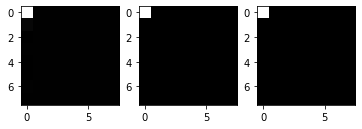

In [7]:
# Visualize
def VisualizeDCT(block):
  plt.subplot(1,3,1)#Y
  plt.imshow(block[0][0][:,:,0],cmap=plt.cm.gray)
  plt.subplot(1,3,2)#Cb
  plt.imshow(block[0][0][:,:,1],cmap=plt.cm.gray)
  plt.subplot(1,3,3)#Cr
  plt.imshow(block[0][0][:,:,2],cmap=plt.cm.gray)
  
VisualizeDCT(dctBlocks)

In [8]:
def Blocks2Img(blocks):
    W = xLen*BLOCK_WIDTH
    H = yLen*BLOCK_HEIGHT
    img = np.zeros((H,W,3))
    for y in range(yLen):
        for x in range(xLen):
            img[y*BLOCK_HEIGHT:y*BLOCK_HEIGHT+BLOCK_HEIGHT, x*BLOCK_WIDTH:x*BLOCK_WIDTH+BLOCK_WIDTH]=blocks[y][x]
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


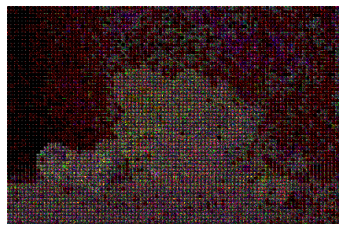

In [9]:
blockImg = Blocks2Img(dctBlocks)

plt.figure()
plt.axis('off')
plt.imshow(blockImg)

## Step 4: Quantization

In [10]:
#quantization table
QY = np.array([[16,11,10,16,24,40,51,61],
               [12,12,14,19,26,58,60,55],
               [14,13,16,24,40,57,69,56],
               [14,17,22,29,51,87,80,62],
               [18,22,37,56,68,109,103,77],
               [24,35,55,64,81,104,113,92],
               [49,64,78,87,103,121,120,101],
               [72,92,95,98,112,100,103,99]])
QC= np.array([[17,18,24,47,99,99,99,99],
              [18,21,26,66,99,99,99,99],
              [24,26,56,99,99,99,99,99],
              [47,66,99,99,99,99,99,99],
              [99,99,99,99,99,99,99,99],
              [99,99,99,99,99,99,99,99],
              [99,99,99,99,99,99,99,99],
              [99,99,99,99,99,99,99,99]])

QY = QY[:BLOCK_WIDTH, :BLOCK_HEIGHT]
QC = QC[:BLOCK_WIDTH, :BLOCK_HEIGHT]
Qmap = np.stack((QY, QC, QC), axis=2) if useYCbCr else np.stack((QY, QY, QY), axis=2)

qDctBlocks = dctBlocks.copy()
qDctBlocks = (qDctBlocks/Qmap).round().astype('int16')

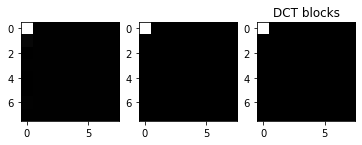

Text(0.5, 1.0, 'Quantized DCT blocks')

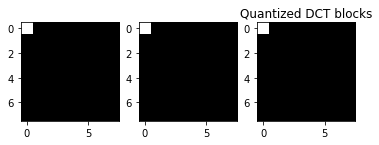

In [11]:
#dct example of one quantized dct block's r-g-b/Y-Cb-Cr channels
VisualizeDCT(dctBlocks)
plt.title("DCT blocks")
plt.show()
VisualizeDCT(qDctBlocks)
plt.title("Quantized DCT blocks")

In [12]:
dctBlocks[0][0][:,:,0], qDctBlocks[0][0][:,:,0]

(array([[ 2.25000000e+02,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 5.91152585e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-5.41196100e-01,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 4.12912601e-01,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-9.26790395e-01,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 1.3065

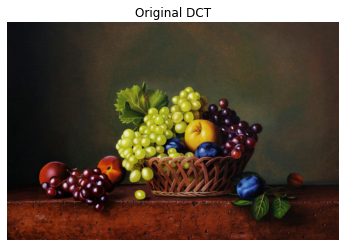

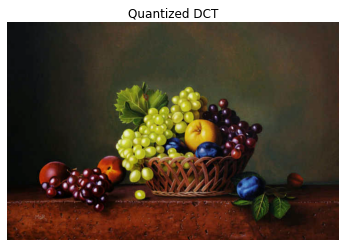

In [13]:
plt.figure()
plt.title("Original DCT")
dedctBlocks=DCTSolveBlocks(dctBlocks,"idct")
I = YCbCr2RGB(Blocks2Img(dedctBlocks)) if useYCbCr else Blocks2Img(dedctBlocks).astype(np.uint8)
plt.imshow(I)
plt.axis('off')
I = cv2.cvtColor(I, cv2.COLOR_RGB2BGR)

plt.figure()
plt.title("Quantized DCT")
dedctBlocks=DCTSolveBlocks(qDctBlocks*Qmap,"idct")
I = YCbCr2RGB(Blocks2Img(dedctBlocks)) if useYCbCr else Blocks2Img(dedctBlocks).astype(np.uint8)
plt.imshow(I)
plt.axis('off')
I = cv2.cvtColor(I, cv2.COLOR_RGB2BGR)

## Step 5: Encode

In [14]:
def Zigzag(block):
  lines=[[] for i in range(BLOCK_HEIGHT+BLOCK_WIDTH-1)] 
  for y in range(BLOCK_HEIGHT): 
    for x in range(BLOCK_WIDTH): 
      i=y+x 
      if(i%2 == 0): 
          lines[i].insert(0,block[y][x]) 
      else:  
          lines[i].append(block[y][x]) 
  return np.array([coefficient for line in lines for coefficient in line])

print(qDctBlocks[0][0][:,:,0])
print("Zigzag: ")
print(Zigzag(qDctBlocks[0][0][:,:,0]))

[[14  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]
Zigzag: 
[14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


### Huffman

In [41]:
!pip install -Uqq huffman

# Constants for Huffman
runBits = 1 #modify it if you want
bitBits = 3  #modify it if you want
rbBits = runBits + bitBits ##(run,bitSize of coefficient)
useYCbCr = True #modify it if you want
useHuffman = True #modify it if you want

In [16]:
import huffman
from collections import Counter

def huffmanCounter(zigZagArr):
    rbCount=[]
    run=0
    for AC in zigZagArr[1:]:
        if(AC!=0):
            AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
            if(run>2**runBits-1):
                runGap=2**runBits
                k=run//runGap
                for i in range(k):
                  rbCount.append('1'*runBits+'0'*bitBits)
                run-=k*runGap
            run=min(run,2**runBits-1) 
            bitSize=min(int(np.ceil(np.log(abs(AC)+0.000000001)/np.log(2))),2**bitBits-1)
            rbCount.append(format(run<<bitBits|bitSize,'0'+str(rbBits)+'b'))
            run=0
        else:
            run+=1
    rbCount.append("0"*(rbBits))
    return Counter(rbCount)


rbCount = np.zeros(3,dtype=Counter)
rbCount[0] = huffmanCounter(Zigzag(qDctBlocks[0][0][:,:,0]))
rbCount[1] = huffmanCounter(Zigzag(qDctBlocks[0][0][:,:,1]))
rbCount[2] = huffmanCounter(Zigzag(qDctBlocks[0][0][:,:,2]))

product = Counter()
for iter in rbCount:
    for k, v in iter.items():
        product[k] += v

rbCount = product
print("(run,bit) counter for Huffman Coding:\n"+str(rbCount))
print("Huffman Coding:\n" + str(huffman.codebook(rbCount.items())))

(run,bit) counter for Huffman Coding:
Counter({'0000': 3})
Huffman Coding:
{'0000': ''}


In [17]:
#Show run-length in a readable way
def runLengthReadable(zigZagArr,lastDC):
    rlc=[]
    run=0
    newDC=min(zigZagArr[0],2**(2**bitBits-1)-1)
    DC=newDC-lastDC
    bitSize=max(0,min(int(np.ceil(np.log(abs(DC)+0.000000001)/np.log(2))),2**bitBits-1))
    rlc.append([np.array(bitSize),DC])
    code=format(bitSize, '0'+str(bitBits)+'b')+"\n"
    if (bitSize>0):
        code=code[:-1]+","+(format(DC,"b") if DC>0 else ''.join([str((int(b)^1)) for b in format(abs(DC),"b")]))+"\n"
    for AC in zigZagArr[1:]:
        if(AC!=0):
            AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
            if(run>2**runBits-1):
                runGap=2**runBits
                k=run//runGap
                for i in range(k):
                    code+='1'*runBits+'0'*bitBits+'\n'
                    rlc.append([runGap-1,0])
                run-=k*runGap
            bitSize=min(int(np.ceil(np.log(abs(AC)+0.000000001)/np.log(2))),2**bitBits-1)
            #VLI encoding (next 2 lines of codes)
            code+=format(run<<bitBits|bitSize,'0'+str(rbBits)+'b')+','
            code+=(format(AC,"b") if AC>=0 else ''.join([str((int(b)^1)) for b in format(abs(AC),"b")]))+"\n"
            rs=np.zeros(1,dtype=object)
            rs[0]=np.array([run,bitSize])
            rs= np.append(rs,AC)
            rlc.append(rs)
            run=0
        else:
            run+=1
    rlc.append([0,0])
    code+="0"*(rbBits)#end
    return np.array(rlc), code, newDC


b = np.zeros(64,dtype=np.int16)
b[0] = 222
b[4] = 9
b[11] = 33
b[12] = 25
b[14] = -129
b[17] = 77
b[27] = 12
b[47] = 82
# print(b)
arr, code, DC = runLengthReadable(b,0)
print("Run-Length code(using VLI):\n" + str(code))

Run-Length code(using VLI):
111,1111111
1000
1100,1001
1000
1000
1000
0110,100001
0101,11001
1111,0000000
1000
0111,1001101
1000
1000
1000
1000
1100,1100
1000
1000
1000
1000
1000
1000
1000
1000
1000
1111,1010010
0000


In [18]:
def runLength(zigZagArr,lastDC,hfm=None):
    rlc=[]
    run=0
    newDC=min(zigZagArr[0],2**(2**bitBits-1))
    DC=newDC-lastDC
    bitSize=max(0,min(int(np.ceil(np.log(abs(DC)+0.000000001)/np.log(2))),2**bitBits-1))
    code=format(bitSize, '0'+str(bitBits)+'b')
    if (bitSize>0):
        code+=(format(DC,"b") if DC>0 else ''.join([str((int(b)^1)) for b in format(abs(DC),"b")]))
    for AC in zigZagArr[1:]:
        if(AC!=0):
            AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
            if(run>2**runBits-1):
                runGap=2**runBits
                k=run//runGap
                for i in range(k):
                    code+=('1'*runBits+'0'*bitBits)if hfm == None else  hfm['1'*runBits+'0'*bitBits]#end
                run-=k*runGap
            run=min(run,2**runBits-1) 
            bitSize=min(int(np.ceil(np.log(abs(AC)+0.000000001)/np.log(2))),2**bitBits-1)
            rb=format(run<<bitBits|bitSize,'0'+str(rbBits)+'b') if hfm == None else hfm[format(run<<bitBits|bitSize,'0'+str(rbBits)+'b')]
            code+=rb+(format(AC,"b") if AC>=0 else ''.join([str((int(b)^1)) for b in format(abs(AC),"b")]))
            run=0
        else:
            run+=1
    code+="0"*(rbBits) if hfm == None else  hfm["0"*(rbBits)]
    return code, newDC

code1,DC = runLength(Zigzag(qDctBlocks[0][0][:,:,0]),0)
code2,DC = runLength(Zigzag(qDctBlocks[0][0][:,:,1]),DC)
code3,DC = runLength(Zigzag(qDctBlocks[0][0][:,:,2]),DC)
codeBlock = code1+code2+code3
print(codeBlock+"\nCompresion size of this block: "+str(len(codeBlock)/8)+"KB\nOriginal size of one block: "+str(BLOCK_WIDTH*BLOCK_HEIGHT*3)+"KB")

10011100000110101111000000100000
Compresion size of this block: 4.0KB
Original size of one block: 192KB


In [19]:
def runLength2bytes(code):
  return bytes([len(code)%8] + [int(code[i:i+8], 2) for i in range(0, len(code), 8)])
  
#Following shows example of the saving and loading process of a block
print(codeBlock + "\n↓Encoding: split by length 8 ")
print(str([codeBlock[i:i+8] for i in range(0, len(codeBlock), 8)]) + "\n↓Transfer to int8 ")
print(str([int(codeBlock[i:i+8],2) for i in range(0, len(codeBlock), 8)]) + "\n↓Save as bytes ")
code2bytes = runLength2bytes(codeBlock)
print(str(code2bytes) + "\n↓Decoding: load as int8 ")
print(str(list(code2bytes)) + "\n↓Transfer to bytes(binary)")
print(str([format(i,'08b') for i in list(code2bytes)]) + "\n↓Join them")
bytes2code = "".join([format(i,'08b') for i in list(code2bytes)])
print(bytes2code)

10011100000110101111000000100000
↓Encoding: split by length 8 
['10011100', '00011010', '11110000', '00100000']
↓Transfer to int8 
[156, 26, 240, 32]
↓Save as bytes 
b'\x00\x9c\x1a\xf0 '
↓Decoding: load as int8 
[0, 156, 26, 240, 32]
↓Transfer to bytes(binary)
['00000000', '10011100', '00011010', '11110000', '00100000']
↓Join them
0000000010011100000110101111000000100000


## Final: Do step 5 for all blocks and save

In [20]:
def huffmanCounterWholeImg(blocks):
    rbCount = np.zeros(xLen*yLen*3,dtype=Counter)
    zz = np.zeros(xLen*yLen*3,dtype=object)
    for y in range(yLen):
        for x in range(xLen):
            for i in range(3):
                zz[y*xLen*3+x*3+i] = Zigzag(blocks[y, x,:,:,i])
                rbCount[y*xLen*3+x*3+i] = huffmanCounter(zz[y*xLen*3+x*3+i])

    product = Counter()
    for iter in rbCount:
        for k, v in iter.items():
            product[k] += v

    return product, zz

rbCount,zz = huffmanCounterWholeImg(qDctBlocks)
hfm = huffman.codebook(rbCount.items())
sortedHfm = [[hfm[i[0]],i[0],rbCount[i[0]]] for i in rbCount.most_common()]
sortedHfm

[['11', '0000', 15930],
 ['10', '0001', 14114],
 ['011', '1000', 6751],
 ['010', '1001', 5831],
 ['001', '0010', 5502],
 ['0000', '0011', 2340],
 ['00010', '1010', 1042],
 ['000111', '0100', 892],
 ['0001100', '0101', 228],
 ['00011011', '1011', 222],
 ['000110101', '1100', 40],
 ['0001101001', '0110', 22],
 ['0001101000', '1101', 3]]

In [24]:
def savingQuantizedDctBlocks(blocks):
    rbCount, zigZag = huffmanCounterWholeImg(blocks)
    hfm = huffman.codebook(rbCount.items())
    sortedHfm = [[hfm[i[0]],i[0]] for i in rbCount.most_common()]
    code = ""
    DC = 0
    for y in range(yLen):
        for x in range(xLen):
            for i in range(3):
                codeNew, DC = runLength(zigZag[y*xLen*3+x*3+i], DC, hfm if useHuffman else None)
                code += codeNew
    savedImg = runLength2bytes(code)

    return bytes([int(format(xLen,'012b')[:8], 2), int(format(xLen, '012b')[8:] + format(yLen, '012b')[:4], 2), int(format(yLen, '012b')[4:], 2)]) + savedImg, sortedHfm

# All in one!

Image original size:     0.97435 MB
Compression image size:  0.03646 MB
Image original pixels:   340560 pixels
Compression ratio:       26.727 : 1
DCT time:                0.24578 seconds
Encoding:                3.90799 seconds


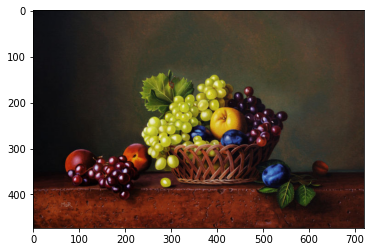

In [36]:
IMAGE_PATH = "images/1.jpg"

img = cv2.imread(IMAGE_PATH, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def jpeg_compression(img):
    global xLen
    global yLen
    xLen = img.shape[1]//BLOCK_WIDTH
    yLen = img.shape[0]//BLOCK_HEIGHT
    img = rgb2ycbcr(img)
    blocks = toBlocks(img)

    startDCT = time.time()
    dctBlocks = DCTSolveBlocks(blocks,"dct")
    endtDCT = time.time()

    qDctBlocks = dctBlocks.copy()
    qDctBlocks=(qDctBlocks/Qmap).round().astype('int16')
    savedImg, sortedHfmForDecode = savingQuantizedDctBlocks(qDctBlocks)

    print("Image original size:     %.5f MB"%(img.size/(2**20)))
    print("Compression image size:  %.5f MB"%(len(savedImg)/2**20))
    print("Image original pixels:   %d pixels"%(img.shape[0]*img.shape[1]))
    print("Compression ratio:       %.3f : 1"%(img.size/2**20/(len(savedImg)/2**20)))
    print("DCT time:                %.5f seconds"%(endtDCT-startDCT))

    return savedImg, sortedHfmForDecode
    
t1 = time.time()
jpeg_compression(img)
t2 = time.time()
print("Encoding:                %.5f seconds"%(t2-t1))

plt.imshow(img)

In [38]:
import glob

for file in glob.glob("images/*.jpg") + glob.glob("images/*.png"):
    print(file)    
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(img.shape)
    t1 = time.time()
    savedImg, sortedHfmForDecode = jpeg_compression(img)
    t2 = time.time()

    saveFile = open(f"{file}_compression.bin", "wb")
    saveFile.write(savedImg)
    saveFile.close()

    print("Encoding:                %.5f seconds"%(t2-t1))
    print("-------------------------------------")

images\1.jpg
(473, 720, 3)
Image original size:     0.97435 MB
Compression image size:  0.03646 MB
Image original pixels:   340560 pixels
Compression ratio:       26.727 : 1
DCT time:                0.26450 seconds
Encoding:                3.95289 seconds
-------------------------------------
images\2.jpg
(504, 700, 3)
Image original size:     1.00937 MB
Compression image size:  0.03032 MB
Image original pixels:   352800 pixels
Compression ratio:       33.296 : 1
DCT time:                0.24947 seconds
Encoding:                5.49911 seconds
-------------------------------------
images\3.jpg
(226, 223, 3)
Image original size:     0.14419 MB
Compression image size:  0.00843 MB
Image original pixels:   50398 pixels
Compression ratio:       17.098 : 1
DCT time:                0.03626 seconds
Encoding:                0.67148 seconds
-------------------------------------
images\4.jpg
(922, 770, 3)
Image original size:     2.03115 MB
Compression image size:  0.10799 MB
Image original pixel